In [11]:
from bankingSystem import * 
from helperFunctions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings 
import multiprocessing
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%pylab inline 
pylab.rcParams['figure.figsize'] = (20, 10)
pylab.rcParams['font.size'] = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [36]:
import numpy as np
import pandas as pd
label = ["baseModel", "highReserve", "highLeverage", "lowCorrelation", "noCorrelation", "lowBorrow", "noBorrow", "301", "302"]

defaultCollection = np.concatenate([np.load("defaultSimulation/defaultCollection_" + l + ".npy") for l in label],axis=0)
defaultBanks = np.concatenate([np.load("defaultSimulation/defaultBanks_" + l + ".npy") for l in label],axis=0)

In [37]:
pd.DataFrame(columns=label, data = defaultCollection.T).describe()

,baseModel,highReserve,highLeverage,lowCorrelation,noCorrelation,lowBorrow,noBorrow,301,302
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,18.799500,13.369000,24.364500,32.043500,1.043500,8.609500,3.523500,0.451000,0.000500
std,18.023005,14.933866,21.593258,13.016502,1.009513,15.047599,11.200231,2.506939,0.022361
min,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,2.000000,7.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,8.000000,18.000000,31.000000,1.000000,2.000000,0.000000,0.000000,0.000000
75%,28.000000,20.000000,37.000000,40.000000,2.000000,9.000000,1.000000,0.000000,0.000000
max,92.000000,92.000000,99.000000,76.000000,6.000000,85.000000,97.000000,37.000000,1.000000


Text(0.5, 0, 'Bank ID')

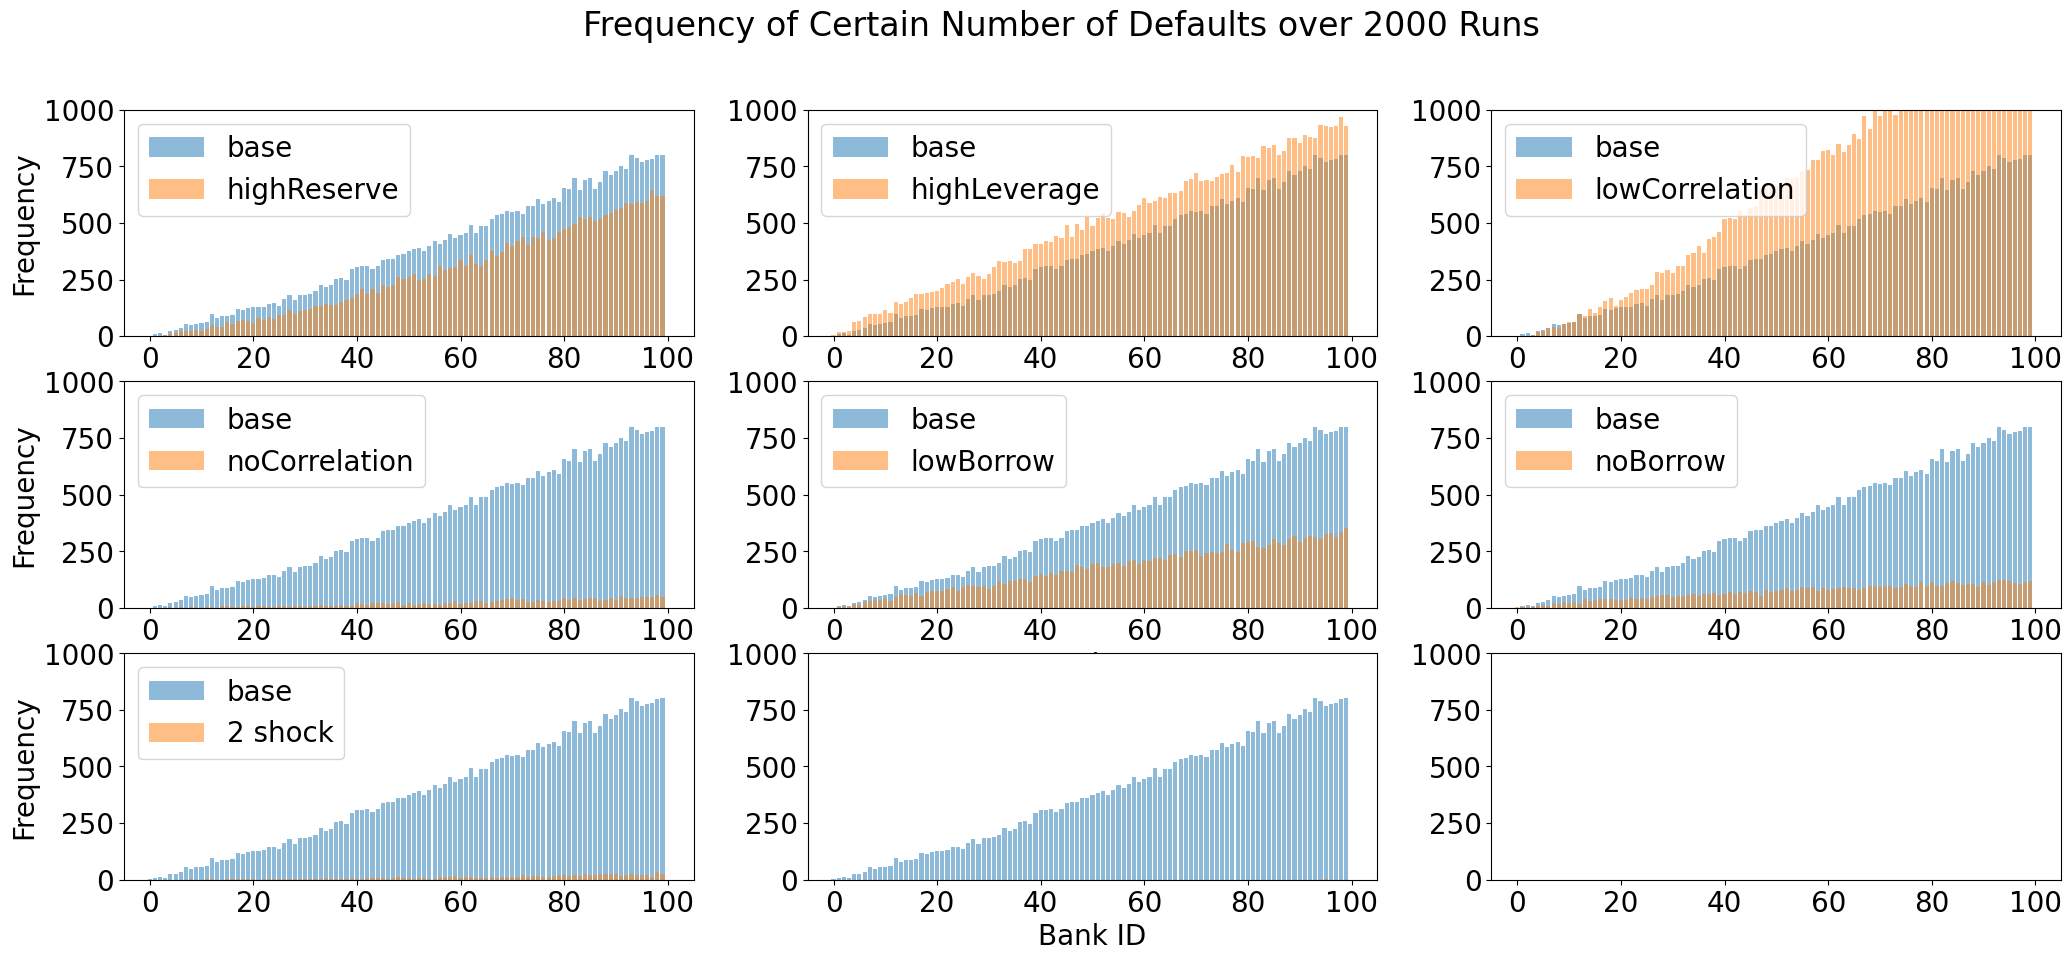

In [38]:
fig, axs = plt.subplots(3, 3, figsize=(25,10))
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (-5, 105)
custom_ylim = (0, 1000)
# Setting the values for all axes.
plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)

fig.suptitle('Frequency of Certain Number of Defaults over 2000 Runs')
axs[0,0].bar(range(100), defaultBanks[0].sum(axis=0), label = "base",alpha=0.5)
axs[0,0].bar(range(100), defaultBanks[1].sum(axis=0), label = "highReserve",alpha=0.5)
axs[0,0].set_ylabel("Frequency")
axs[0,0].legend()
axs[0,1].bar(range(100), defaultBanks[0].sum(axis=0), label = "base",alpha=0.5)
axs[0,1].bar(range(100), defaultBanks[2].sum(axis=0), label = "highLeverage",alpha=0.5)
axs[0,1].legend()
axs[0,2].bar(range(100), defaultBanks[0].sum(axis=0), label = "base",alpha=0.5)
axs[0,2].bar(range(100), defaultBanks[3].sum(axis=0), label = "lowCorrelation",alpha=0.5)
axs[0,2].legend()
axs[1,0].bar(range(100), defaultBanks[0].sum(axis=0), label = "base",alpha=0.5)
axs[1,0].bar(range(100), defaultBanks[4].sum(axis=0), label = "noCorrelation",alpha=0.5)
axs[1,0].set_ylabel("Frequency")
axs[1,0].legend()
axs[1,1].bar(range(100), defaultBanks[0].sum(axis=0), label = "base",alpha=0.5)
axs[1,1].bar(range(100), defaultBanks[5].sum(axis=0), label = "lowBorrow",alpha=0.5)
axs[1,1].set_xlabel("Bank ID")
axs[1,1].legend()
axs[1,2].bar(range(100), defaultBanks[0].sum(axis=0), label = "base",alpha=0.5)
axs[1,2].bar(range(100), defaultBanks[6].sum(axis=0), label = "noBorrow",alpha=0.5)
axs[1,2].legend()

axs[2,0].bar(range(100), defaultBanks[0].sum(axis=0), label = "base",alpha=0.5)
axs[2,0].bar(range(100), defaultBanks[7].sum(axis=0), label = "2 shock",alpha=0.5)
axs[2,0].set_ylabel("Frequency")
axs[2,0].legend()
axs[2,1].bar(range(100), defaultBanks[0].sum(axis=0), label = "base",alpha=0.5)
axs[2,1].bar(range(100), defaultBanks[8].sum(axis=0), label = "3 shock",alpha=0.5)
axs[2,1].set_xlabel("Bank ID")
# axs[2,1].legend()
# axs[2,2].bar(range(100), defaultBanks[0].sum(axis=0), label = "base",alpha=0.5)
# axs[2,2].bar(range(100), defaultBanks[9].sum(axis=0), label = "5 shock",alpha=0.5)
# axs[2,2].legend()